## About This
* [kaggle days tokyo オフラインコンペ参戦記 by ML_Bear](https://naotaka1128.hatenadiary.jp/entry/kaggle_days_tokyo_2019)

## References
* [lgbm_starter_kaggledaystokyo by @senkin13](https://www.kaggle.com/senkin13/lgbm-starter-kaggledaystokyo)
* [KaggleDays Tokyo Starter Kernel by @inversion](https://www.kaggle.com/inversion/kaggledays-tokyo-starter-kernel)

## Load Libraries & Set params

In [1]:
import re
import os
import gc
import ast
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import MeCab
from collections import defaultdict
from gensim import corpora, models, matutils

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GroupKFold

from functools import partial
from multiprocessing import Pool
from joblib import Parallel, delayed, cpu_count

WORKERS = cpu_count()
LDA_DIMENSION = 5
PASSES = 10
ACCESS_TIME_COLUMN_NAME = 'ts_unix_time'

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 400)

In [3]:
EXEC_NAME = 'test_8'

In [4]:
TEST_MODE = False
N_SPLITS = 5
TE_THRESHOLD = 500

TARGET_NAME = 'age'
PK = 'user_id'
KEY_COLUMNS = [PK]
DATE_COLUMNS = ['ts']

## Define Utility Functions

In [5]:
num_partitions = cpu_count()
num_cores = cpu_count()

def parallelize_dataframe(df, func, columnwise=False):
    num_partitions = cpu_count()
    num_cores = cpu_count()
    pool = Pool(num_cores)

    if columnwise:
        df_split = [df[col_name] for col_name in df.columns]
        df = pd.concat(pool.map(func, df_split), axis=1)
    else:
        df_split = np.array_split(df, num_partitions)
        df = pd.concat(pool.map(func, df_split))

    pool.close()
    pool.join()

    return df

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min() * len(df) * 3
            c_max = df[col].max() * len(df) * 3
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
                        .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data & Preprocess

In [7]:
df_train = reduce_mem_usage(pd.read_csv('./data/train.csv'))
df_test = reduce_mem_usage(pd.read_csv('./data/test.csv'))

Mem. usage decreased to 83.71 Mb (0.0% reduction)
Mem. usage decreased to 54.46 Mb (0.0% reduction)


In [8]:
df_test['age'] = 1000
df = pd.concat([df_train, df_test])

del df_train, df_test
gc.collect()

20

### Preprocess datetime

In [9]:
def process_datetime(df):
    df['ts'] = pd.to_datetime(df['ts'])
    df['ts_unix_time'] = pd.DatetimeIndex(df.ts).astype(np.int64) * 1e-9
    
    df['dayofweek'] = df['ts'].dt.dayofweek
    df['is_weekend'] = (df['ts'].dt.weekday >=5).astype(int)
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['second'] = df['ts'].dt.second
    return df

df = process_datetime(df)
# df.head()

### Parse article meta-data

In [10]:
df_article = pd.read_pickle('./data/kiji_metadata.pickle')
df_article = df_article.rename(columns={'kiji_id_raw': 'kiji_id'})
df_article['display_time'] = pd.to_datetime(
    df_article['display_time']).apply(lambda x: x.tz_localize(None))
# df_article.head(1)

In [11]:
def genres_parser(data):
    if data=='None': return None
    return ','.join(x['name'] for x in ast.literal_eval(data))

df_article['parsed_genres'] = df_article['genres'].fillna('None').apply(genres_parser)
# df_article['parsed_genres']

In [12]:
def label_parser(data):
    if data=='None': return None
    return ','.join(x['label'] for x in ast.literal_eval(data))

df_article['parsed_labels'] = df_article['belong_topic_info'].fillna('None').apply(label_parser)
# df_article['parsed_labels']

In [13]:
def kw_parser(data):
    if data=='None': return None
    return ','.join(ast.literal_eval(data))

df_article['parsed_keywords'] = df_article['keywords'].fillna('None').apply(kw_parser)
# df_article['parsed_keywords']

In [14]:
df_article['title_merged'] = df_article.title + df_article.title2.fillna('') + df_article.title3.fillna('')
# df_article['title_merged']

In [15]:
tagger = MeCab.Tagger()

def parse_sentense(data):
    if data=='None': return None
    
    kw_list = []
    tmp = tagger.parse(data).split('\n')
    for t in tmp:
        try:
            if t.split('\t')[1].split(',')[0]=='名詞':
                kw_list.append(t.split('\t')[0])
        except:
            pass
        
    return kw_list


def kw_parser(data):
    if data=='None': return None
    return ','.join(data)


df_article['title_keywords'] = df_article.title_merged.fillna('None').apply(parse_sentense)
df_article['parsed_title_keywords'] = df_article['title_keywords'].fillna('None').apply(kw_parser)
# df_article['parsed_title_keywords']

In [16]:
"""
# since this is too slow, I was not able to use this column for my final result.
df['body_keywords'] = df.body.fillna('None').apply(parse_sentense)
df['body_keywords']
"""

"\n# since this is too slow, I was not able to use this column for my final result.\ndf['body_keywords'] = df.body.fillna('None').apply(parse_sentense)\ndf['body_keywords']\n"

### merge article meta data

In [17]:
rows = [
    'kiji_id',
    'display_time',
    'service_category',
    #'title',
    #'title2',
    #'title3',
    'parsed_genres',
    'parsed_labels',
    'parsed_keywords',
    'parsed_title_keywords',
    #'belong_topic_info',
    #'keywords',
    'body',
    'moji_count'
]
df = pd.merge(df, df_article.loc[:, rows], on='kiji_id', how='left')
# df.head(3)

## Features

In [18]:
df_uid = pd.DataFrame(df.user_id.unique(),columns=['user_id'])
df_uid.head()

,user_id
0,1010270
1,1844640
2,1886080
3,2155080
4,3194050


### Some Basic Features

In [19]:
df['os'] = df.er_dev_os_family + df.er_dev_os_version
df['os_major_ver'] = df.er_dev_os_version.apply(lambda x: str(x).split('.')[0])
df['os_major'] =  df.er_dev_os_family + df.os_major_ver

In [20]:
df['browser'] = df.er_dev_browser_family + df.er_dev_browser_version
df['browser_major'] = df.er_dev_browser_family + df.er_dev_browser_version.apply(lambda x: str(x).split('.')[0])
df['browser_minor'] = df.er_dev_browser_family + df.er_dev_browser_version.apply(lambda x: '.'.join(str(x).split('.')[:2]))

In [21]:
df['diff_view_and_upload'] = pd.DatetimeIndex((df.ts - df.display_time)).astype(np.int64) * 1e-9
df['red_moji_count'] = df.moji_count * df.ig_ctx_red_viewed_percent
df['red_moji_per_time'] = df.red_moji_count / df.ig_ctx_red_elapsed_since_page_load
df['is_er_dev_manufacture_apple'] = df.er_dev_manufacture == 'Apple'

### Target Encodings Features

In [22]:
# CAUTION: This is NOT a good target encoding implementation.
def target_encoding(pvs, key, prefix='all_te_'):
    pvs = pvs[pvs.age < 1000]  # train data (dirty implementation...)
    agg_func = {
        'age': ['mean', 'count']
    }
    agg_pvs = pvs.groupby([key]).agg(agg_func)
    agg_pvs.columns = [prefix + '_'.join(col).strip() for col in agg_pvs.columns.values]
    agg_pvs.reset_index(inplace=True)
    agg_pvs = agg_pvs[agg_pvs[prefix+'age_count'] > TE_THRESHOLD]
    return agg_pvs.drop([prefix+'age_count'], axis=1)

target_columns = [
    'ig_usr_connection',
    'ig_ctx_product',
    'er_geo_pref_j_name',
    'er_geo_country_code',
    'er_geo_city_j_name',
    'er_dev_os_version',
    'er_dev_os_family',
    'er_dev_device_type',
    'er_dev_browser_family',
    'er_dev_browser_version',
    'er_dev_device_name',

    'os',
    'os_major',
    'browser',
    'browser_major',
    'browser_minor',
    
    'service_category',
    'parsed_genres',
    'parsed_labels',
    
    # I should use kiji_id as target enoded feature column
    # 'kiji_id',  
]

for column in target_columns:
    df_enc = target_encoding(df, column, prefix='all_te_{}_'.format(column))
    df = pd.merge(df, df_enc, on=column, how='left')

# df.head(10)

### Feature aggregation

In [23]:
def aggregate_pvs(pvs, prefix):  
    agg_func = {
        'kiji_id': ['count', 'nunique'],
        'age': ['mean'],
        'ts_unix_time': [np.ptp, 'std'],
        
        'diff_view_and_upload': ['mean', 'max', 'min', 'std'],
        'red_moji_count': ['mean', 'max', 'min', 'std'],
        'red_moji_per_time': ['mean', 'max', 'min', 'std'],
        'is_er_dev_manufacture_apple': ['nunique'],
        
        'er_dev_browser_family': ['nunique'],
        'er_dev_browser_version': ['nunique'],
        'er_dev_device_name': ['nunique'],
        'er_dev_device_type': ['nunique'],
        'er_dev_os_family': ['nunique'],
        'er_dev_os_version': ['nunique'],
        'er_geo_bc_flag': ['nunique', 'max', 'min', 'mean'],
        'er_geo_country_code': ['nunique'],
        'er_rfc_kiji_id_raw': ['nunique'],
        'er_rfs_reffered_visit': ['nunique'],
                
        'dayofweek': ['nunique', 'mean', 'max', 'min', 'std'],
        'hour': ['nunique', 'mean', 'max', 'min', 'std'],
        'minute': ['nunique', 'std'],
        'second': ['nunique', 'std'],
        'is_weekend': ['nunique', 'mean', 'max', 'min', 'std'],
        
        'diff_view_and_upload': ['sum', 'mean', 'max', 'min', 'std'],

        'ig_ctx_red_viewed_percent': ['nunique', 'mean', 'max', 'min', 'std'],
        'ig_ctx_red_elapsed_since_page_load': ['nunique', 'mean', 'max', 'min', 'std'],    

        'all_te_ig_usr_connection_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_ig_ctx_product_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_geo_pref_j_name_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_geo_country_code_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_geo_city_j_name_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_dev_os_version_age_mean': ['nunique', 'mean', 'max', 'min', 'std'], 
        'all_te_er_dev_os_family_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_dev_device_type_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_dev_device_name_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_dev_browser_family_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_er_dev_browser_version_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],

        'all_te_os_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_os_major_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_browser_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_browser_major_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_browser_minor_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],

        'all_te_service_category_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_parsed_genres_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
        'all_te_parsed_labels_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],

        # I should use kiji_id as target enoded feature column
        # 'all_te_kiji_id_age_mean': ['nunique', 'mean', 'max', 'min', 'std'],
    }

    agg_pvs = pvs.groupby([PK]).agg(agg_func)
    agg_pvs.columns = [
        prefix + '_'.join(col).strip() 
        for col in agg_pvs.columns.values
    ]
    agg_pvs.reset_index(inplace=True)
    
    df = (pvs.groupby(PK)
                    .size()
                    .reset_index(name='pv_count'))
    df.rename(
        columns={'pv_count': prefix + 'pv_count'},
        inplace=True
    )
    
    return pd.merge(df, agg_pvs, on=PK, how='left')

In [24]:
df_agg = aggregate_pvs(df, prefix= 'all_')
df_agg = df_agg.rename(columns={'all_age_mean': 'age'})
# df_agg.head(10)

In [25]:
# merge
df_uid = pd.merge(df_uid, df_agg, on=PK, how='left')

### LDA Features

In [26]:
def generate_log(df, log_base_columns):
    log_column_name = PK + '_' + log_base_columns + '_logs'
    df_tmp = pd.DataFrame()
    df_tmp[PK] = df.user_id.unique()

    tmp = df.sort_values(by=ACCESS_TIME_COLUMN_NAME, ascending=True)\
                   .dropna(subset=[log_base_columns])\
                   .groupby(PK)[log_base_columns]\
                   .apply(lambda x: "%s" % ','.join(x))
    tmp.rename(log_column_name, inplace=True)

    df_tmp = pd.merge(df_tmp, tmp, on=PK, how='left')
    
    return df_tmp, log_column_name


def calc_vecs(dictionary, lda, log):
    doc = log.split(',')
    vec = dictionary.doc2bow(doc)
    return matutils.sparse2full(lda[vec], lda.num_topics)


def process(log_column_name, dictionary, lda, df_logs):
    f = partial(calc_vecs, dictionary, lda)
    vecs = df_logs[log_column_name].map(f)
    for i in range(lda.num_topics):
        df_logs['LDA_{}_{}'.format(log_column_name, i)] = [vec[i] for vec in vecs]
    return df_logs.drop([log_column_name], axis=1)


def process_lda(df, df_uid, column):
    file_name = f'./data/features/lda_{column}.pickle'
    
    if file_name in glob.glob(file_name):
        df_tmp = pd.read_pickle(file_name)
    else:
        df_tmp, log_column_name = generate_log(df, column)
        
        docs = df_tmp[log_column_name].apply(lambda x: x.split(','))
        dictionary = corpora.Dictionary(docs)
        corpus = [dictionary.doc2bow(doc) for doc in docs]
        
        lda = models.LdaMulticore(
            corpus=corpus, id2word=dictionary, workers=WORKERS, random_state=42, passes=PASSES, 
            num_topics=LDA_DIMENSION, minimum_probability=0.001)
        
        f = partial(process, log_column_name, dictionary, lda)
        df_tmp = parallelize_dataframe(df_tmp, f)
        df_tmp.to_pickle(file_name)
        
    return pd.merge(df_uid, df_tmp, on=PK, how='left')
    

In [27]:
df_uid = process_lda(df, df_uid, 'parsed_genres')
df_uid = process_lda(df, df_uid, 'parsed_labels')
df_uid = process_lda(df, df_uid, 'parsed_keywords')
df_uid = process_lda(df, df_uid, 'parsed_title_keywords')
# df_uid = process_lda(df, df_uid, 'parsed_body_keywords')

## Data Cleaning

In [28]:
def remove_constant_columns(df, key_columns, target_name):
    remove = []
    for col in df.columns:
        if col in key_columns + [target_name]:
            continue
        if df[col].std() == 0:
            remove.append(col)

    if len(remove) > 0:
        print('constant columns: {}'.format(remove))
        df.drop(remove, axis=1, inplace=True)

    return df


def df_cleaning(df, key_columns=KEY_COLUMNS, target_name='age'):
    df = df.loc[:, sorted(df.columns)]
    df = remove_constant_columns(df, key_columns, target_name)
    return df


df_uid = df_cleaning(df_uid)

## Split Train/Test

In [29]:
df_train = df_uid[df_uid.age!=1000]
df_test = df_uid[df_uid.age==1000]

In [30]:
X_train = df_train.drop(KEY_COLUMNS + [TARGET_NAME], axis=1)
y_train = df_train[TARGET_NAME]
X_test = df_test.drop(KEY_COLUMNS + [TARGET_NAME], axis=1)
print(X_train.shape)

(14088, 176)


## Train

In [31]:
def get_lightgbm_params():
    # these params are determined by optuna tuning
    return {
        'objective': 'regression',
        "boosting_type": "gbdt",
        "metric": 'rmse',
        'learning_rate': 0.03,
        'num_leaves': 27,
        'min_data_in_leaf': 259,        
        'lambda_l1': 2.4138549585708125e-05,
        'lambda_l2': 0.10858125429062318,
        'bagging_fraction': 0.9990190705461549,
        'bagging_freq': 3,
        'feature_fraction': 0.4561095815938466
    }

param = get_lightgbm_params()

In [32]:
oof = np.zeros(len(X_train))
pred = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

# seed averaging
seeds = [42, 1230, 302, 1128, 1022]
for seed in seeds:
    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X_train)):
        train_data = lgb.Dataset(
            X_train.iloc[train_idx],
            label=y_train.iloc[train_idx])
        valid_data = lgb.Dataset(
            X_train.iloc[valid_idx],
            label=y_train.iloc[valid_idx])

        model = lgb.train(param, train_data, num_boost_round=5000,
                        valid_sets = [valid_data],
                        verbose_eval=1000, early_stopping_rounds=100)

        pred += model.predict(
            X_test, num_iteration=model.best_iteration) / N_SPLITS / len(seeds)

        oof[valid_idx] += model.predict(
            X_train.iloc[valid_idx], num_iteration=model.best_iteration) / len(seeds)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = X_train.columns
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[380]	valid_0's rmse: 11.4541
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[292]	valid_0's rmse: 11.6971
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[308]	valid_0's rmse: 11.3397
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[353]	valid_0's rmse: 11.5684
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[433]	valid_0's rmse: 11.5841
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[329]	valid_0's rmse: 11.5576
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[350]	valid_0's rmse: 11.6936
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[351]	

In [33]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))** .5

oof_score = rmse(y_train, oof)
round(oof_score, 4)

11.4974

## Plot Feature Importance

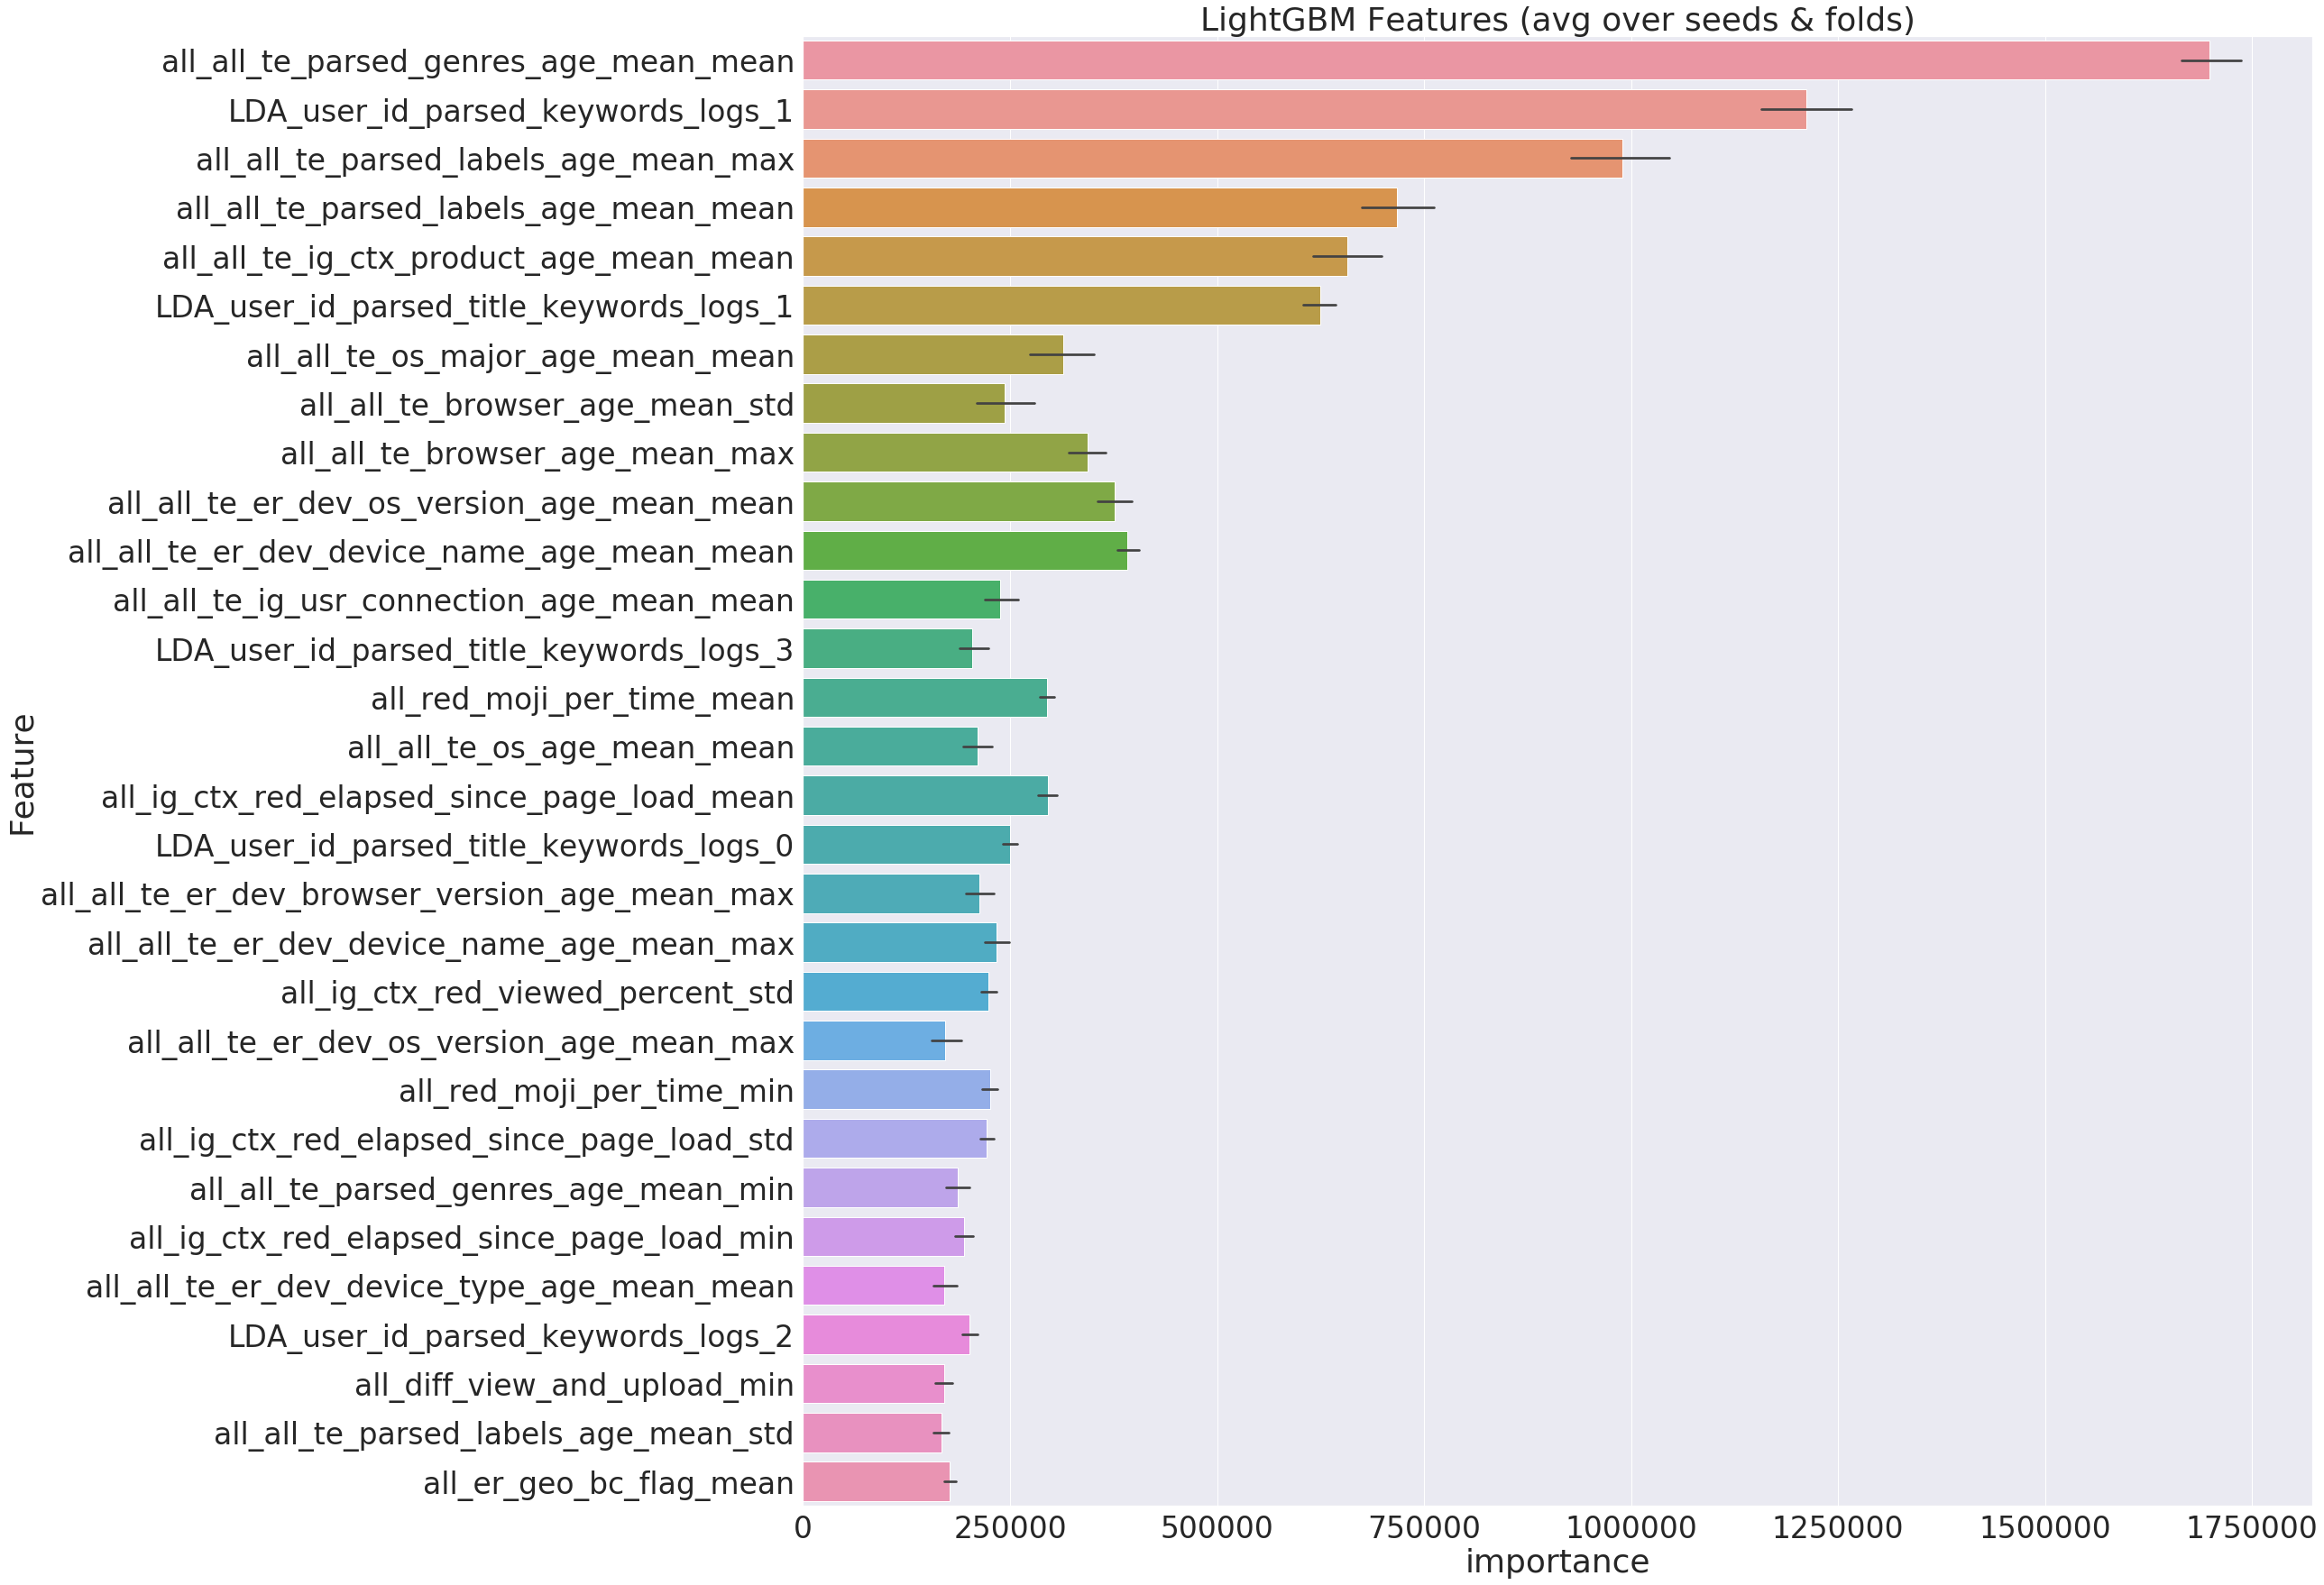

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(font_scale=3)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(30,30))
sns.barplot(x="importance", y="Feature",
                     data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over seeds & folds)')
plt.show()

In [35]:
feature_importances = feature_importance_df[["Feature", "importance"]]\
                                                    .groupby("Feature")\
                                                    .mean()\
                                                    .sort_values(by="importance", ascending=False)
df_importance = feature_importances['importance'] / feature_importances['importance'].sum()
list(df_importance[df_importance == 0].index)

['all_er_geo_bc_flag_min', 'all_is_weekend_min']

In [36]:
list(df_importance[df_importance < 0.0005].index)

['all_all_te_er_dev_os_family_age_mean_max',
 'all_is_weekend_nunique',
 'all_all_te_er_dev_browser_version_age_mean_min',
 'all_all_te_er_dev_browser_family_age_mean_min',
 'all_all_te_ig_ctx_product_age_mean_nunique',
 'all_all_te_browser_minor_age_mean_std',
 'all_all_te_browser_major_age_mean_min',
 'all_is_weekend_max',
 'all_er_dev_os_version_nunique',
 'all_all_te_browser_minor_age_mean_min',
 'all_all_te_ig_usr_connection_age_mean_nunique',
 'all_all_te_er_dev_os_family_age_mean_min',
 'all_er_geo_country_code_nunique',
 'all_all_te_er_geo_pref_j_name_age_mean_nunique',
 'all_all_te_er_dev_os_version_age_mean_nunique',
 'all_all_te_os_age_mean_nunique',
 'all_all_te_service_category_age_mean_nunique',
 'all_dayofweek_min',
 'all_all_te_er_geo_country_code_age_mean_max',
 'all_all_te_er_geo_country_code_age_mean_mean',
 'all_is_er_dev_manufacture_apple_nunique',
 'all_all_te_er_dev_os_family_age_mean_nunique',
 'all_all_te_er_geo_country_code_age_mean_std',
 'all_er_dev_os_famil

## Make Submission File

In [37]:
df_test['age'] = pred
df_test.loc[:, ['user_id', 'age']].to_csv('./data/submit/{}_oof_{}.csv'.format(
    EXEC_NAME, round(oof_score, 4)
), index=False)